To do: remove coins that have lack of history.  Many do not exist before 2021.

In [1]:
import portfolio_utils as pu
import constants as c

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

In [2]:
#Select Rebalance Dates in constants file


#Portfolio Start and Stop Dates
start="2021-01-01" 
endp1="2021-09-12"

# some nice code curtesy of Kevin
agg_data = list()
#data_path = "data/binance_api_sym_history.csv"
crypto = pu.get_data(c.symbols, c.stems)#pd.read_csv(data_path)#, index_col="tradeDate")

crypto.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Base asset volume,Number of trades,Taker buy volume,Taker buy base asset volume,Ignore,symbol,Open_time_,Close_time_
26,1630022400000,478.2,495.0,467.1,494.5,1.549791e+06,1630108799999,7.478714e+08,967190,799046.7263,3.857594e+08,0,BNBUSDT,2021-08-27,2021-08-27 23:59:59.999
27,1630108800000,494.6,497.0,482.3,486.2,8.918546e+05,1630195199999,4.347572e+08,647241,445617.7873,2.172718e+08,0,BNBUSDT,2021-08-28,2021-08-28 23:59:59.999
28,1630195200000,486.1,495.5,475.0,479.7,9.107739e+05,1630281599999,4.414231e+08,535858,448184.5940,2.173212e+08,0,BNBUSDT,2021-08-29,2021-08-29 23:59:59.999
29,1630281600000,479.7,480.9,457.0,460.3,1.125498e+06,1630367999999,5.321771e+08,645920,560117.8346,2.650346e+08,0,BNBUSDT,2021-08-30,2021-08-30 23:59:59.999
30,1630368000000,460.2,477.8,448.2,463.9,1.477346e+06,1630454399999,6.870976e+08,753856,731442.2170,3.402950e+08,0,BNBUSDT,2021-08-31,2021-08-31 23:59:59.999


In [3]:
#min_time="0000-01-01"
#max_time="2099-01-01"
#for sy in c.symbols:
#    times = crypto.loc[crypto.symbol == sy,"Close_time_"]
#    if min_time < min(times):
#        min_time = min(times)
#    if max_time > max(times):
#        max_time = max(times)
#print("max time = ", max_time)
#print("min time = ", min_time)
c.symbols

['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'BNBUSDT']

In [5]:
crypto.shape

(5356, 15)

In [9]:
crypto_ = crypto[["Close_time_", "symbol", "Close"]] #crypto_ = crypto[["tradeDate", "symbol", "avg_latest"]]
crypto_.columns=["tradeDate", "symbol", "Close"]
crypto_ = crypto_.pivot_table(index="tradeDate", columns="symbol", values = "Close")
crypto2_ = crypto_.pct_change()
crypto2_ = crypto2_[1:]
crypto2_.head()

symbol,BNBUSDT,BTCUSDT,ETHUSDT,LTCUSDT
tradeDate,,,,
2018-01-02 23:59:59.999,0.031361,0.096794,0.132836,0.111046
2018-01-03 23:59:59.999,0.067585,0.016654,0.092075,-0.034610
2018-01-04 23:59:59.999,-0.017304,0.009386,0.006392,-0.024166
2018-01-05 23:59:59.999,0.628656,0.126222,0.020532,0.032361
2018-01-06 23:59:59.999,0.517716,0.006450,0.046711,0.144425


In [10]:
#min_time="0000-01-01"
#max_time="9999-01-01"
#for sy in c.symbols:
#    print(sy)
#    temp = crypto2_.loc[:,sy].dropna()
#    if min_time < min(temp.index.values):
#        min_time = min(temp.index.values)
#        print("min time", min_time)
#    if max_time > max(temp.index.values):
#        max_time = max(temp.index.values)
#        print("max time", max_time)

In [39]:
sim_sum=10000
initial_investment = 10000
#potfolio_SR = np.zeros(sim_sum)
a = np.zeros(((sim_sum,len(c.symbols))))
portfolio_df = pd.DataFrame(a)
portfolio_df.columns = c.symbols
portfolio_df["Portfolio_SR"] = -999

for i in tqdm(range(sim_sum)):
    symbol_count = random.randint(2,len(c.symbols))
    symbol_sublist = random.sample(c.symbols, symbol_count)
    portfolio_weights = np.random.dirichlet(np.ones(symbol_count))

    df = crypto2_[symbol_sublist]
    clean_return_history = df.reset_index(drop=True)
    clean_return_history['date']=pu.date_cleaner(pd.Series(crypto2_.index.values).astype(str))
    
    # Instantiate the portfolio object
    portfolio_obj = pu.Portfolio(
        data=clean_return_history, 
        symbols=symbol_sublist, 
        weights=portfolio_weights, 
        initial_investment=initial_investment,
        start_date=start,
        end_date=endp1, 
        rebalance_dates=c.rebalance_dates)
    # estimate returns
    portfolio_obj.estimate_portfolio_returns()
    #print(portfolio_obj.get_sharpe_report())
    portfolio_df.loc[i,symbol_sublist] = portfolio_weights
    portfolio_df.loc[i,"Portfolio_SR"] = portfolio_obj.get_sharpe_ratio()
portfolio_df.to_csv(
    "data/random_portfolios_"+min(crypto.Close_time_.astype(str))+"_to_"+max(crypto.Close_time_.astype(str))+".csv", index=False)

100%|██████████| 10000/10000 [18:56<00:00,  8.80it/s]


Text(0.5, 1.0, 'Random Portfolios')

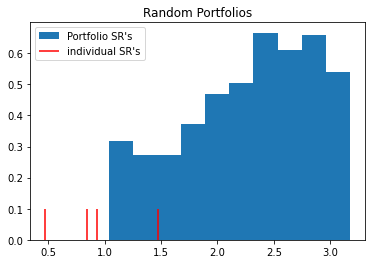

In [40]:
#clean_return_history
ind_SR = np.sqrt(365)*np.mean(crypto2_, axis=0)/np.std(crypto2_, axis=0)
_=plt.hist(portfolio_df["Portfolio_SR"], label="Portfolio SR's", density=True)
plt.vlines(x=ind_SR[c.symbols],ymin=0, ymax=.1, color="red", label="individual SR's")
_=plt.legend()
plt.title("Random Portfolios")

In [41]:
portfolio_df.loc[portfolio_df.Portfolio_SR>max(ind_SR[c.symbols]),:].shape

(8718, 5)

In [45]:
portfolio_df.sort_values(by=['Portfolio_SR'],ascending=False).head(500)

,BTCUSDT,ETHUSDT,LTCUSDT,BNBUSDT,Portfolio_SR
2129,0.000000,0.501681,0.000000,0.498319,3.173725
6399,0.000000,0.505495,0.000000,0.494505,3.173717
9036,0.000000,0.499346,0.000000,0.500654,3.173714
9981,0.000000,0.506307,0.000000,0.493693,3.173711
3095,0.000000,0.497968,0.000000,0.502032,3.173703
3458,0.000000,0.495806,0.000000,0.504194,3.173678
6280,0.000000,0.510861,0.000000,0.489139,3.173654
8578,0.000000,0.511626,0.000000,0.488374,3.173640
2957,0.000000,0.511652,0.000000,0.488348,3.173640
3815,0.000000,0.514530,0.000000,0.485470,3.173576


In [43]:
crypto2_.head()

symbol,BNBUSDT,BTCUSDT,ETHUSDT,LTCUSDT
tradeDate,,,,
2018-01-02 23:59:59.999,0.031361,0.096794,0.132836,0.111046
2018-01-03 23:59:59.999,0.067585,0.016654,0.092075,-0.034610
2018-01-04 23:59:59.999,-0.017304,0.009386,0.006392,-0.024166
2018-01-05 23:59:59.999,0.628656,0.126222,0.020532,0.032361
2018-01-06 23:59:59.999,0.517716,0.006450,0.046711,0.144425
